In [20]:
import pandas as pd
import numpy as np
import sqlite3
import time
import os
import random
import matplotlib.pyplot as plt
import networkx as nx
from itertools import combinations
from collections import Counter



In [24]:
os.chdir('C:\\Users\\mrmus\\Documents\\GitHub\\arxiv-analysis')

conn = sqlite3.connect('arxiv_metadata.db')
c = conn.cursor()

c.execute('''SELECT * FROM metadata ORDER BY published DESC''')
data = c.fetchall()

In [38]:
df = pd.DataFrame(data)
df.columns = ['id', 'title', 'abstract', 'subject', 'published', 'updated', 'authors']

df.head(10)

,id,title,abstract,subject,published,updated,authors
0,2306.03092,Neuralangelo: High-Fidelity Neural Surface Rec...,Neural surface reconstruction has been shown...,cs.CV,2023-06-05 17:59:57,2023-06-05 17:59:57,"Zhaoshuo Li, Thomas M\""uller, Alex Evans, Russ..."
1,2306.03091,RepoBench: Benchmarking Repository-Level Code ...,Large Language Models (LLMs) have greatly ad...,cs.CL cs.AI cs.SE,2023-06-05 17:59:41,2023-06-05 17:59:41,"Tianyang Liu, Canwen Xu, Julian McAuley"
2,2306.03090,Is ChatGPT a Good Teacher Coach? Measuring Zer...,"Coaching, which involves classroom observati...",cs.CL cs.AI,2023-06-05 17:59:21,2023-06-05 17:59:21,"Rose E. Wang, Dorottya Demszky"
3,2306.03089,Brain Diffusion for Visual Exploration: Cortic...,A long standing goal in neuroscience has bee...,cs.CV,2023-06-05 17:59:05,2023-06-05 17:59:05,"Andrew F. Luo, Margaret M. Henderson, Leila We..."
4,2306.03088,DeepGraphDMD: Interpretable Spatio-Temporal De...,Functional brain dynamics is supported by pa...,cs.AI cs.LG,2023-06-05 17:58:49,2023-06-05 17:58:49,"Md Asadullah Turja, Martin Styner and Guorong Wu"
5,2306.03087,Signatures of primordial black holes in gravit...,The possible existence of primordial black h...,astro-ph.CO,2023-06-05 17:58:15,2023-06-05 17:58:15,"Sarah Libanore, Michele Liguori, Alvise Raccan..."
6,2306.03086,Dismantling Hate: Understanding Hate Speech Tr...,Social media has emerged as a popular platfo...,cs.SI,2023-06-05 17:57:40,2023-06-05 17:57:40,"Edinam Kofi Klutse, Samuel Nuamah-Amoabeng, Ha..."
7,2306.03085,Nonparametric Detection of Gerrymandering in M...,"Partisan gerrymandering, i.e., manipulation ...",stat.AP,2023-06-05 17:56:41,2023-06-05 17:56:41,"Wojciech S{\l}omczy\'nski, Dariusz Stolicki, S..."
8,2306.03084,The stellar mass of the Gaia-Sausage/Enceladus...,The Gaia-Sausage/Enceladus (GS/E) structure ...,astro-ph.GA,2023-06-05 17:56:17,2023-06-05 17:56:17,"James Lane, Jo Bovy, Ted Mackereth"
9,2306.03083,MotionDiffuser: Controllable Multi-Agent Motio...,"We present MotionDiffuser, a diffusion based...",cs.RO cs.AI,2023-06-05 17:55:52,2023-06-05 17:55:52,"Chiyu Max Jiang, Andre Cornman, Cheolho Park, ..."


In [39]:
# save a portion of the dataset for testing
# i did 3.5% so the file would be <100mb and i can upload to github

# df.sample(frac=0.035).to_csv("arxiv_sample.csv")

In [36]:
df = pd.read_csv("arxiv_sample.csv")

In [31]:
print("Paper Count:", len(df))
print("NA Count:", any(df.isna().sum())) # No missing data, good

Paper Count: 79436
NA Count: False


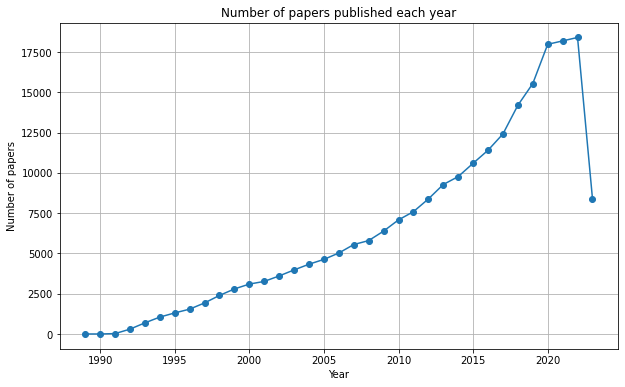

In [37]:
# number of papers published each year

df['published'] = pd.to_datetime(df['published'])
papers_per_year = df['published'].dt.year.value_counts().sort_index()

plt.figure(figsize=(10,6))
plt.plot(papers_per_year.index, papers_per_year.values, marker='o')
plt.xlabel("Year")
plt.ylabel('Number of papers')
plt.title('Number of papers published each year')
plt.grid(True)
plt.show()


In [ ]:
# category frequency count



In [ ]:
# subject abbreviation definitions
subject_map = {
    'astro-ph': 'Astrophysics',
    'astro-ph.CO': 'Cosmology and Nongalactic Astrophysics',
    'astro-ph.EP': 'Earth and Planetary Astrophysics',
    'astro-ph.GA': 'Astrophysics of Galaxies',
    'astro-ph.HE': 'High Energy Astrophysical Phenomena',
    'astro-ph.IM': 'Instrumentation and Methods for Astrophysics',
    'astro-ph.SR': 'Solar and Stellar Astrophysics',
    'cond-mat.dis-nn': 'Disordered Systems and Neural Networks',
    'cond-mat.mes-hall': 'Mesoscale and Nanoscale Physics',
    'cond-mat.mtrl-sci': 'Materials Science',
    'cond-mat.other': 'Other Condensed Matter',
    'cond-mat.quant-gas': 'Quantum Gases',
    'cond-mat.soft': 'Soft Condensed Matter',
    'cond-mat.stat-mech': 'Statistical Mechanics',
    'cond-mat.str-el': 'Strongly Correlated Electrons',
    'cond-mat.supr-con': 'Superconductivity',
    'cs.AI': 'Artificial Intelligence',
    'cs.AR': 'Hardware Architecture',
    'cs.CC': 'Computational Complexity',
    'cs.CE': 'Computational Engineering, Finance, and Science',
    'cs.CG': 'Computational Geometry',
    'cs.CL': 'Computation and Language',
    'cs.CR': 'Cryptography and Security',
    'cs.CV': 'Computer Vision and Pattern Recognition',
    'cs.CY': 'Computers and Society',
    'cs.DB': 'Databases',
    'cs.DC': 'Distributed, Parallel, and Cluster Computing',
    'cs.DL': 'Digital Libraries',
    'cs.DM': 'Discrete Mathematics',
    'cs.DS': 'Data Structures and Algorithms',
    'cs.ET': 'Emerging Technologies',
    'cs.FL': 'Formal Languages and Automata Theory',
    'cs.GL': 'General Literature',
    'cs.GR': 'Graphics',
    'cs.GT': 'Computer Science and Game Theory',
    'cs.HC': 'Human-Computer Interaction',
    'cs.IR': 'Information Retrieval',
    'cs.IT': 'Information Theory',
    'cs.LG': 'Machine Learning',
    'cs.LO': 'Logic in Computer Science',
    'cs.MA': 'Multiagent Systems',
    'cs.MM': 'Multimedia',
    'cs.MS': 'Mathematical Software',
    'cs.NA': 'Numerical Analysis',
    'cs.NE': 'Neural and Evolutionary Computing',
    'cs.NI': 'Networking and Internet Architecture',
    'cs.OH': 'Other Computer Science',
    'cs.OS': 'Operating Systems',
    'cs.PF': 'Performance',
    'cs.PL': 'Programming Languages',
    'cs.RO': 'Robotics',
    'cs.SC': 'Symbolic Computation',
    'cs.SD': 'Sound',
    'cs.SE': 'Software Engineering',
    'cs.SI': 'Social and Information Networks',
    'cs.SY': 'Systems and Control',
    'econ.EM': 'Econometrics',
    'eess.AS': 'Audio and Speech Processing',
    'eess.IV': 'Image and Video Processing',
    'eess.SP': 'Signal Processing',
    'gr-qc': 'General Relativity and Quantum Cosmology',
    'hep-ex': 'High Energy Physics - Experiment',
    'hep-lat': 'High Energy Physics - Lattice',
    'hep-ph': 'High Energy Physics - Phenomenology',
    'hep-th': 'High Energy Physics - Theory',
    'math.AC': 'Commutative Algebra',
    'math.AG': 'Algebraic Geometry',
    'math.AP': 'Analysis of PDEs',
    'math.AT': 'Algebraic Topology',
    'math.CA': 'Classical Analysis and ODEs',
    'math.CO': 'Combinatorics',
    'math.CT': 'Category Theory',
    'math.CV': 'Complex Variables',
    'math.DG': 'Differential Geometry',
    'math.DS': 'Dynamical Systems',
    'math.FA': 'Functional Analysis',
    'math.GM': 'General Mathematics',
    'math.GN': 'General Topology',
    'math.GR': 'Group Theory',
    'math.GT': 'Geometric Topology',
    'math.HO': 'History and Overview',
    'math.IT': 'Information Theory',
    'math.KT': 'K-Theory and Homology',
    'math.LO': 'Logic',
    'math.MG': 'Metric Geometry',
    'math.MP': 'Mathematical Physics',
    'math.NA': 'Numerical Analysis',
    'math.NT': 'Number Theory',
    'math.OA': 'Operator Algebras',
    'math.OC': 'Optimization and Control',
    'math.PR': 'Probability',
    'math.QA': 'Quantum Algebra',
    'math.RA': 'Rings and Algebras',
    'math.RT': 'Representation Theory',
    'math.SG': 'Symplectic Geometry',
    'math.SP': 'Spectral Theory',
    'math.ST': 'Statistics Theory',
    'math-ph': 'Mathematical Physics',
    'nlin.AO': 'Adaptation and Self-Organizing Systems',
    'nlin.CD': 'Chaotic Dynamics',
    'nlin.CG': 'Cellular Automata and Lattice Gases',
    'nlin.PS': 'Pattern Formation and Solitons',
    'nlin.SI': 'Exactly Solvable and Integrable Systems',
    'nucl-ex': 'Nuclear Experiment',
    'nucl-th': 'Nuclear Theory',
    'physics.acc-ph': 'Accelerator Physics',
    'physics.ao-ph': 'Atmospheric and Oceanic Physics',
    'physics.app-ph': 'Applied Physics',
    'physics.atm-clus': 'Atomic and Molecular Clusters',
    'physics.atom-ph': 'Atomic Physics',
    'physics.bio-ph': 'Biological Physics',
    'physics.chem-ph': 'Chemical Physics',
    'physics.class-ph': 'Classical Physics',
    'physics.comp-ph': 'Computational Physics',
    'physics.data-an': 'Data Analysis, Statistics and Probability',
    'physics.ed-ph': 'Physics Education',
    'physics.flu-dyn': 'Fluid Dynamics',
    'physics.gen-ph': 'General Physics',
    'physics.geo-ph': 'Geophysics',
    'physics.hist-ph': 'History and Philosophy of Physics',
    'physics.ins-det': 'Instrumentation and Detectors',
    'physics.med-ph': 'Medical Physics',
    'physics.optics': 'Optics',
    'physics.plasm-ph': 'Plasma Physics',
    'physics.pop-ph': 'Popular Physics',
    'physics.soc-ph': 'Physics and Society',
    'physics.space-ph': 'Space Physics',
    'q-bio.BM': 'Biomolecules',
    'q-bio.CB': 'Cell Behavior',
    'q-bio.GN': 'Genomics',
    'q-bio.MN': 'Molecular Networks',
    'q-bio.NC': 'Neurons and Cognition',
    'q-bio.OT': 'Other Quantitative Biology',
    'q-bio.PE': 'Populations and Evolution',
    'q-bio.QM': 'Quantitative Methods',
    'q-bio.SC': 'Subcellular Processes',
    'q-bio.TO': 'Tissues and Organs',
    'q-fin.CP': 'Computational Finance',
    'q-fin.EC': 'Economics',
    'q-fin.GN': 'General Finance',
    'q-fin.MF': 'Mathematical Finance',
    'q-fin.PM': 'Portfolio Management',
    'q-fin.PR': 'Pricing of Securities',
    'q-fin.RM': 'Risk Management',
    'q-fin.ST': 'Statistical Finance',
    'q-fin.TR': 'Trading and Market Microstructure',
    'quant-ph': 'Quantum Physics',
    'stat.AP': 'Applications',
    'stat.CO': 'Computation',
    'stat.ME': 'Methodology',
    'stat.ML': 'Machine Learning',
    'stat.OT': 'Other Statistics',
    'stat.TH': 'Statistics Theory'
}

subject_aliases = {
    'math.MP': 'math-ph',
    'stat.TH': 'math.ST',
    'math.IT': 'cs.IT',
    'q-fin.EC': 'econ.GN',
    'cs.SY': 'eess.SY',
    'cs.NA': 'math.NA'
}

In [8]:
unlisted_subs = [element for sublist in df['subject'].apply(lambda x: x.split()) for element in sublist]

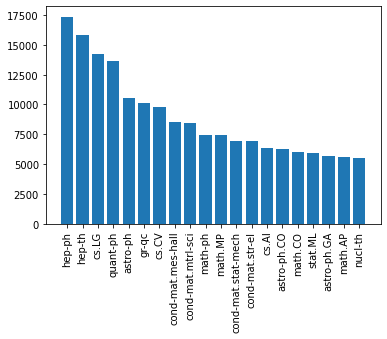

In [13]:
subject_counts = Counter([sub for subject in df['subject'].apply(lambda x: x.split(' ')) for sub in subject])

subjects, counts = zip(*subject_counts.most_common(20))

plt.bar(subjects, counts)
plt.xticks(rotation=90)
plt.show()

In [ ]:
import plotly.graph_objects as go

# Get the 10 most common subjects
top_subjects = subject_counts.most_common(10)

# Unzip the subjects and counts into two lists
subjects, counts = zip(*top_subjects)

# Create a bar chart
fig = go.Figure(data=go.Bar(
    x=subjects,
    y=counts,
    hovertext=[f'Subject: {s}<br>Count: {c}' for s, c in top_subjects],
))

fig.update_layout(
    title_text='Top 10 subjects by number of papers',
    xaxis_title='Subjects',
    yaxis_title='Number of papers',
)

fig.show()

In [ ]:
# show most popular subject of each year


In [15]:
combos = df['subject'].apply(lambda x: x.split()).apply(lambda x: list(combinations(sorted(x), 2)))
combo_counts = Counter([item for sublist in combos.tolist() for item in sublist])

In [ ]:
random.seed(5)

G = nx.Graph()

for subjects, count in combo_counts.most_common(5000):
    G.add_edge(subjects[0], subjects[1], weight=count)

plt.figure(figsize=(20,20))
pos = nx.spring_layout(G)

nx.draw_networkx_nodes(G, pos, node_size=700)
nx.draw_networkx_edges(G, pos, width=6)
nx.draw_networkx_labels(G, pos, font_size=20, font_family='sans-serif')

plt.axis('off')
plt.show()

In [30]:
len(combo_counts)

9284